# Continuous Control
## Solution to Continuous control Environment to Udacity Deep Reinforcement Learning course project 2.


### Import necessary environmental libraries

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

### Determine if GPU is available

In [2]:
# Check Cuda is available
if torch.cuda.is_available():
    # Get Device Count
    GPUCount = torch.cuda.device_count()
    
    # Print Device Names
    print("Devices Available:")
    for i in range(0, GPUCount):
        print(i,": ", torch.cuda.get_device_name(i))

    # Check Current Device and Print Explicit Message
    print("\nCurrent Device in use is Device #",
          torch.cuda.current_device(),": ",
          torch.cuda.get_device_name(torch.cuda.current_device()))
    
    device = torch.device("cuda:0")
    
else:
    device = torch.device("cpu")
    print("CUDA Not Available!\nWill Train on CPU")

Devices Available:
0 :  GeForce GTX 1080

Current Device in use is Device # 0 :  GeForce GTX 1080


### Lead the reacher Environment

In [3]:
env = UnityEnvironment(file_name="Reacher20_Windows_x86_64/Reacher.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Get Environment details and store ralevant information

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain)

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000

### Import relevent libraries for actor critic agent

In [5]:
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


### Create Actor Neural Network

In [6]:
class Actor(nn.Module):
    """Actor (Policy) Model."""
    
    def __init__(self, state_size, action_size, seed, fc1_units = 512, fc2_units = 512):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))
    

### Create Critic Neural Network

In [7]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=512, fc2_units=512):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


## Define the DDPG agent
## Imports

In [8]:
import random
import copy
from collections import namedtuple, deque
import torch.optim as optim

### Hyper parameters

In [9]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 1024        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0.   # weight decay

### Noise Funtion

In [10]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * np.random.normal((self.mu - x) ,self.sigma,self.size)
        self.state = x + dx
        
        #print(self.state)
        return self.state

### Replay Buffer

In [11]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### DDPG Agent Class

In [12]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, no_of_agents, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.n_agents = no_of_agents
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
    def step(self, train, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for i in range(self.n_agents):
            self.memory.add(state[i], action[i], reward[i], next_state[i], done[i])

        
    def start_learn(self):
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)
    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            #for i in range(self.n_agents):
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
            """Soft update model parameters.
            θ_target = τ*θ_local + (1 - τ)*θ_target

            Params
            ======
                local_model: PyTorch model (weights will be copied from)
                target_model: PyTorch model (weights will be copied to)
                tau (float): interpolation parameter 
            """
            for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

   ### Create Agent

In [13]:
agent = Agent(num_agents, state_size, action_size,8)

### DDPG Processing function

In [14]:
def ddpg(n_episodes=150, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores_buffer =[]
    train = False;
    
    env_info = env.reset(train_mode=True)[brain_name]            # reset the environment
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]            # reset the environment
        agent.reset()
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        
        
        for t in range(max_t):
            actions = agent.act(states, add_noise = True)
            
            env_info = env.step( actions )[brain_name]
            
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            
            if(t%num_agents == 0):
                for _ in range(num_agents//2):               
                    agent.start_learn();
            agent.step(train, states, actions, rewards, next_states, dones)
            
            #print("States: ", states);
            
            states = next_states
            scores += rewards
            train = False
            
            if np.any( dones ): 
                break 
        scores_deque.append(scores)
        scores_buffer.append(scores)
        print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_buffer[len(scores_buffer) - 1]) , np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores_buffer

In [15]:
scores = ddpg()

Episode 100	Average Score: 26.67 Score: 26.67
Episode 150	Score: 38.19	Average Score: 38.68

In [16]:
print(scores)
scores_store = scores;

[array([0.11      , 0.15      , 0.14      , 0.47999999, 0.24999999,
       0.15      , 0.11      , 0.34999999, 0.88999998, 0.13      ,
       0.31999999, 0.03      , 0.13      , 1.07999998, 0.79999998,
       0.18      , 0.49999999, 0.52999999, 0.16      , 0.84999998]), array([0.34999999, 0.28999999, 0.54999999, 0.23999999, 0.22999999,
       0.02      , 0.16      , 0.19      , 0.        , 0.98999998,
       0.33999999, 0.82999998, 0.21      , 0.04      , 0.08      ,
       0.13      , 0.19      , 0.27999999, 0.27999999, 0.39999999]), array([0.43999999, 0.52999999, 0.52999999, 0.35999999, 0.60999999,
       0.31999999, 0.        , 0.54999999, 0.90999998, 0.47999999,
       0.1       , 0.07      , 1.65999996, 0.19      , 0.        ,
       0.08      , 0.22999999, 0.51999999, 0.38999999, 0.22999999]), array([0.13      , 0.41999999, 0.37999999, 1.05999998, 0.98999998,
       1.86999996, 0.49999999, 0.96999998, 0.98999998, 0.1       ,
       1.23999997, 1.49999997, 0.66999999, 0.52999999, 

In [ ]:
scores = scores_store;

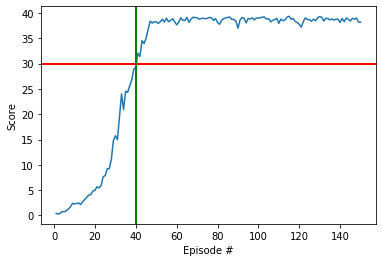

Solved at Episode:  40


In [36]:
fig = plt.figure()
scores_average = []
pass_episode = 0
for i in range(len(scores)):
    scores_average.append(np.mean(scores[i]));
    if(scores_average[i] >= 30 and pass_episode == 0):
        pass_episode = i;
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_average)+1), scores_average)
plt.axhline(30,0,150, color='r', linewidth=2.0 )
plt.axvline(pass_episode,0,40, color='g', linewidth=2.0 )
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
print("Solved at Episode: ", pass_episode);